# Assignment #4
**CE4719: Deep Learing**


*   Spring 2020
*   http://ce.sharif.edu/courses/98-99/2/ce719-1/index.php

**Please pay attention to these notes:**

<br/>

- The items you need to answer are highlighted in red and the coding parts you need to implement are denoted by:
```
      ########################################
      #     Put your implementation here     #
      ########################################
```
- We always recommend discussion in groups for assignments. However, each student should finish all of the questions by him/herself. 
- All submitted code will be compared against all student's codes using Stanford MOSS.
- If you have any questions about this assignment, feel free to drop us a line. You may also post your questions on the course's forum page.
- We HIGHLY encourage you to run this notebook on Google Colab.
- **Before starting to work on the assignment, please fill your name in the next section *AND remember to RUN the cell.***





In [0]:
#@title Enter your information & "RUN the cell!!"
student_id = "98208824" #@param {type:"string"}
student_name = "Sadroddin Barikbin" #@param {type:"string"}

print("your student id:", student_id)
print("your name:", student_name)


## 1. Language Model (29 + 7 pts)

---




Recurrent neural networks have shown excellent performance in language modeling, especially in recognizing a language's underlying structure and grammar. Having a well-trained language model can help us to understand natural language inputs, which can improve down-stream tasks. However, training a recurrent neural network has always been a challenging task. In this section, we will train a neural language model and get familiar with regularization techniques that are specially optimized for RNNs.

For this section, we will use [Wikitext](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) as our dataset, which is a corpus collected from Wikipedia's featured articles. Wikitext has two distinct features: 1- It is a document-level dataset and will enable the model to learn long-term dependencies (generating a paragraph) 2- It is a well-cleaned dataset and can be used with minimum pre-processing steps.

### 1.1 Loading the data

First, let's download the dataset

In [0]:
! wget -q https://github.com/kazemnejad/ce4719-hw04-assets/raw/master/wikitext-2-v2.zip
! unzip -e wikitext-2-v2.zip

Archive:  wikitext-2-v2.zip
  inflating: wikitext-2/train.txt    
  inflating: wikitext-2/valid.txt    
  inflating: wikitext-2/vocab.pk     


Here is a sneak peek at our dataset:

In [0]:
! head -n 5 wikitext-2/train.txt 

 = Berkley Bedell = <eol> <eol> Berkley Warren Bedell ( born March 5 , 1921 ) is a former U.S. Representative from Iowa . After starting a successful business in his youth , Berkley Fly Co . , he ran for the United States Congress in 1972 , but was defeated by incumbent Wiley Mayne . In 1974 , however , Bedell beat Wiley Mayne and was elected to Congress . <eol> He was known for his support of representative democracy and his populist style . For example , he would hold town halls and let constituents vote on motions to decide what he would do in Congress on their behalf . These meetings helped Bedell understand the problems of his constituents ; as a result , he backed issues that were important to his farming constituency , such as waterway usage fees and production constraints . <eol> He did not seek reelection in 1986 after contracting <unk> disease from a tick bite . Though he no longer serves in Congress , Bedell remains active in Iowa politics , strongly supporting Howard Dean i

As you can see, every line contains a full article consisting of several paragraphs (`<eol>` token is basically a `\n`). 

Here is one article:

In [0]:
print(open('wikitext-2/train.txt').readlines()[13].replace(' <eol>', '\n'))

 = Old Baltimore Pike =

 Old Baltimore Pike is a road in the U.S. state of Delaware . The road , known as New Castle County Road 26 , runs from Maryland Route 281 ( MD 281 ) at the Maryland state line south of Newark , Delaware and continues east to Christiana , ending near Delaware Route 1 ( DE 1 ) . The road is paralleled by Interstate 95 ( I @-@ 95 , Delaware Turnpike ) to the north and U.S. Route 40 ( US 40 , Pulaski Highway ) to the south . The Old Baltimore Pike was built before 1720 and connected Elkton , Maryland to Christiana . It was a turnpike called the Elk and Christiana Turnpike between 1817 and 1838 . In the past it served as a major connection between Philadelphia and Baltimore .

 = = Route description = =

 Old Baltimore Pike begins at the Delaware – Maryland state line near Newark , Delaware , where the highway continues west into that state as MD 281 . The road heads northeast from the state line through wooded residential areas as a two @-@ lane undivided road , i

In order to train the model, we need to feed the data into it. However, the shape of the input data in each iteration and how the model's input affects its performance still remain challenging. One method is to divide the dataset into its sentences and train the model on those sentences. The problem with this method is that it would never allow the model to learn inter-sentence dependencies. On the other hand, one might use paragraphs as the model's inputs. But, since our dataset is a document-level one, it would be wasteful to ignore paragraph-level relations. To sidestep these issues, we view the dataset as a single and very long string and let the model figure out all associations, such as the definition of sentences and paragraphs. In the following steps,  we will implement this method in an efficient data pipeline.

In [26]:
# Imports

import random
import pickle
import tempfile
from typing import Dict, List, Tuple

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
from torch.nn import LSTM
import torch.nn.functional as F

import nltk
nltk.download('punkt')
from nltk import word_tokenize
from  torch.distributions.categorical import Categorical
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", category=UserWarning)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
cuda


In [0]:
# Input pipeline parameters
BATCH_SIZE = 80
BASE_WINDOW_SIZE = 70
VAR_BPTT_STD = 5
VAR_BPTT_PROB = 0.95

In [0]:
class LMDataset(IterableDataset):
  def __init__(self, split_path: str, word2id: Dict[str, int],  
               shuffle=False, batch_size=BATCH_SIZE, base_window_size=BASE_WINDOW_SIZE,
               variational_bptt_window=False, variational_bptt_std=VAR_BPTT_STD,
               variational_bptt_prob=VAR_BPTT_PROB):
    """
    Args: 
      split_path: path to the dataset file
      shuffle: whether to shuffle the dataset
      batch_size: the batch size
      id2word, word2id: dataset's vocabulary
      variational_bptt_window: 
    """
    super(LMDataset).__init__()

    self.split_path = split_path
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.word2id = word2id
    self.base_window_size = base_window_size
    self.variational_bptt_window = variational_bptt_window
    self.variational_bptt_std = variational_bptt_std
    self.variational_bptt_prob = variational_bptt_prob

    ### Optinal: you can put additinal codes below here ###
    

  def _initialize(self):
    """
    See section 1.1.1

    This method initalizes the dataset by reading 
    the file from disk and applying minimum pre-processing
    """
    # A list of word ids
    token_ids = []

    with open(self.split_path) as data_file:
      data=data_file.read().split('\n')
      if self.shuffle:
        random.shuffle(data)
      tokens='\n'.join(data).split()
      token_ids=list(map(lambda tok:self.word2id[tok.lower()] if (tok.lower() in self.word2id) else self.word2id['<unk>'],tokens))

    self.token_ids = torch.tensor(token_ids, dtype=torch.int64)

  def __next__(self) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    See section 1.1.2 and 1.1.3

    Returns the next batch of data.

    Returns:
      x: a 2d (bs x window_size) tensor containing the input word ids
      y: a 2d (bs x window_size) tensor, similar to x's shape, 
          containing target word ids

    Dont forget to use self.batch_size as the batch size
      and self.base_seq_len as the window size 
    """
    x=[]
    y=[]
    row_length=int(len(self.token_ids)/self.batch_size)
    data=self.token_ids
    window=self.base_window_size if not self.variational_bptt_window else max(1,int(random.gauss(self.base_window_size*0.5**np.random.binomial(1,self.variational_bptt_prob),self.variational_bptt_std)))
    end_x=self.curr_batch*self.base_window_size if not self.variational_bptt_window else self.last_x+window
    if end_x>=row_length:
      raise StopIteration()
    length=min(window,row_length-end_x-1)
    for i in range(self.batch_size):
      start=i*row_length+end_x
      x+=[list(data[start:start+length])]
      y+=[list(data[start+1:start+1+length])]
      if len(x[-1])==0 or len(y[-1])==0:
        raise StopIteration()
    self.curr_batch+=1
    self.last_x=end_x
    return torch.tensor(x,dtype=torch.long), torch.tensor(y,dtype=torch.long)

  def __iter__(self):
    """
    This method get called only at begining of the iteration
    """
    self._initialize()
    self.curr_batch=0
    self.last_x=0
    ### Optinal: you can put additinal codes below here ###

    return self

#### 1.1.1 Read and Tokenize (3 pts)

First, we need to load the dataset file and apply some preprocessing on it. Specifically, you need to: 
1. Read the file from the disk.
2. Shuffle articles if required (please note that every line in the dataset represents a single Wikipedia article).
3. Concatenate all articles into one big string.
4. Tokenize it (since the dataset is already tokenized, you can get all tokens by simply splitting the big string by whitespaces).
5. Convert all tokens into their corresponding ids (the unknown token is `<unk>`. Make sure that you will use it for out-of-vocabulary tokens)

*Note: Run the following cell before implementing this section*



In [0]:
vocab = pickle.load(open('wikitext-2/vocab.pk', 'rb'))
word2id, id2word = vocab['word2id'], vocab['id2word']
print("word2ids:", list(word2id.items())[:10])

word2ids: [('the', 0), (',', 1), ('.', 2), ('<unk>', 3), ('of', 4), ('and', 5), ('in', 6), ('to', 7), ('a', 8), ('<eol>', 9)]


Check your implementation

In [36]:
train_ds = LMDataset('wikitext-2/train.txt', shuffle=True, word2id=word2id)
it = iter(train_ds)

assert train_ds.token_ids.shape[0] == 2130493
assert train_ds.token_ids.sum() == 3692975507
print("Passed!")

Passed!


#### 1.1.2 Create batches (6 pts)


Up to this point, we only have a single list of tokens, which basically contains the whole dataset. Training a recurrent network on such a big sequence is practically impossible since there is no way that we can backprop through millions of time-steps. Moreover, the GPU's memory is minimal, so that it will exhaust on the first few hundred steps. Therefore, we have no choice other than splitting the big string into smaller chunks. Obviously, by chunking the dataset into equal-sized sequences, the sentences or paragraphs might get cut in the middle. However, we should accept this tradeoff in order to train the model.

Let's start with a straightforward chunking-technique. Imagine that we have a 40-token string; we divide it into eight 5-token substrings, and the batch size is 4:

<p align="center">
<img src="https://imgur.com/download/6HjGVpG"/>
</p>

In each iteration, the RNN is computed independently for every row of the batch. Take the first batch as an example: The RNN for the second row starts from the token $t_6$, which can be in the middle of the original sequence. Such restriction for such a short and close dependency can significantly hurt the model's performance.

Now imagine another approach to this issue. Take the original sequence of 40 elements. Divide it into 4 (the batch size) long sequences.
<p align="center">
<img src="https://imgur.com/download/NXLfuaI"/>
</p>
Now, given a backpropagation window size of 4, we can create the batches as following:
<p align="center">
<img src="https://imgur.com/download/RFFyZHD"/>
</p>

So let's discuss why this technique is actually better. First of all, dividing the big string by batch size (which in here is 4) produces very long rows. Each row may contain several articles (as opposed to the previous method in which each row merely contains few sentences). Therefore, most of the contents between any two consecutive rows are independent. Secondly, creating batches by moving a window across the horizontal axis enables us to use the hidden states computed from the previous batch. For instance, in the figure above, we can initialize the RNN's hidden states of the second batch with the final states of batch one. Although the gradients do not flow from the second batch to the first one, the RNN can have access to some information from the previous chunk. 

In this section, we are going to implement the last chunking method. Specifically, you should complete the implementation of the `LMDataset.__next__()` method. In the future, this function will be used to iterate through the dataset. Therefore, on each call, it should return the next model's inputs and ground truth labels (Note that labels are the shifted inputs in the language modeling task). To implement the method, first, divide the tokens_ids by the batch size (to have equally-sized subsequences, you should drop the remainder). Then, generate batches according to the algorithm mentioned above. Please note that the final batches may not have the same window size. Also, when there are no more batches to generate, raise a `StopIteration` exception.

Check your implementation:

In [37]:
# Create a dummy dataset
with tempfile.NamedTemporaryFile('w', delete=False) as f:
  dummy_ds = ' '.join([str(i) for i in range(1, 41)]) + '\n'
  f.write(dummy_ds)
  
dummy_word2id = {str(i): i for i in range(1, 41)}
dummy_word2id.update({'<unk>': 1})
dummy_ds = LMDataset(f.name, shuffle=True, word2id=dummy_word2id,
                     batch_size=4, base_window_size=5)
xys = list(dummy_ds)
assert len(xys) == 2
assert torch.all(xys[0][0] == torch.tensor([[ 1,  2,  3,  4,  5],
        [11, 12, 13, 14, 15],
        [21, 22, 23, 24, 25],
        [31, 32, 33, 34, 35]]))
assert torch.all(xys[0][1] == torch.tensor([[ 2,  3,  4,  5,  6],
          [12, 13, 14, 15, 16],
          [22, 23, 24, 25, 26],
          [32, 33, 34, 35, 36]]))
assert torch.all(xys[1][0] == torch.tensor([[ 6,  7,  8,  9],
          [16, 17, 18, 19],
          [26, 27, 28, 29],
          [36, 37, 38, 39]]))
assert torch.all(xys[1][1] == torch.tensor([[ 7,  8,  9, 10],
          [17, 18, 19, 20],
          [27, 28, 29, 30],
          [37, 38, 39, 40]]))

print('Passed!')

Passed!


#### 1.1.3 Variable backpropagation window size (3.5 pts)

Although we have managed to make the batching as efficient as possible and made use of final hidden states from the previous training iteration as an initialization for the current batch, some of the elements still receive no backpropagation window at all.  

Given a window size of 5, how many dataset elements receive no backpropagation windows? (5 pts)

In the example above ,last column items meaning 4 items do not get backprop window.

To remedy this problem, we can use a variable window size that is randomly sampled. Such a procedure will prevent those elements from being at the same position within the backprop window among different epochs. Therefore, when given enough training epochs, we will anticipate that every element receives an adequate backpropagation window. Specifically, we use the following formula to calculate the window size for every batch:

$$
\text{ } \\
\hat{w} = \left\{ \begin{array}{rl}
\mathcal{W} &\mbox{with probability} \ p \\
\frac{1}{2} . \mathcal{W} &\mbox{with probability} 1-p
\end{array} \right.
\\ \text{ }
\\ \text{ }
w \sim \mathcal{N}(\hat{w}, \sigma)
$$

where $\mathcal{W}$ is the default window size, $p$ is the a probability close to 1, $\sigma$ is the standard deviation, and $w$ is the final window size.

In this section, you should edit the `__next__(self)` method to incoporate a variable window size. Since we will the same class for our validation data, the variable mechanism should be only activated when `self.variational_bptt_window` flag is true.


Check your implementation

In [38]:
xys = list(LMDataset('wikitext-2/train.txt', shuffle=True, word2id=word2id, 
                    variational_bptt_window=True))[:100]
assert np.mean([x.shape[1] for x, y in xys]) != BASE_WINDOW_SIZE

xys = list(LMDataset('wikitext-2/train.txt', shuffle=True, word2id=word2id, 
                    variational_bptt_window=False))[:100]
assert np.mean([x.shape[1] for x, y in xys]) == BASE_WINDOW_SIZE
print('Passed!')

Passed!


### 1.2 Implementing the model

<p align="center">
<img src="https://imgur.com/download/LeK6lQh"/>
</p>

For this assignment, we will use a simple stacked LSTM architecture and various regularized techniques to improve the model's performance and overfitting. Our primary regularization method is Dropout. But, vanilla Dropout is not quite suitable for RNNs. So, as we will explain in the following sections, some modifications are required. 

#### 1.2.1 ConnectionDrop LSTM (Optional: 6 pts)

The problem with the standard Dropout in the context of RNNs is that it generates a new binary mask every time it gets called. Howerver, such behavior is problematic in RNNs. If we use the original Dropout on the hidden-to-hidden connection, then the RNN cell will receive a completely different mask for every timestep (in a non-recurrent layer, the Dropout mask for its inputs remains consistent through forward and backward flow). One of the methods to solve that issue is applying Dropout on the layer/cell's weight (instead of activation), which is similar to removing connections between two consecutive layers. As this Dropout only gets called once per each training step, the repeated computation of an RNN cell would not be a problem.

In this section, we would like to extend the vanilla LSTM layer so that it applies weight dropout on its hidden-to-hidden connection. The corresponding weight for the mentioned connection is called `weight_hh_l0`. Implement this functionality in the below class:

In [0]:
class ConnectionDropLSTM(LSTM):
  def __init__(self, *args, dropout_rate=0.0, **kwargs):
    super(ConnectionDropLSTM, self).__init__(*args, **kwargs)
    self.dropout_rate = dropout_rate
    self.is_renamed = False

  def flatten_parameters(self, *arg, **kwargs):
    # Do not change this. This is a temp fix for a wierd 
    # issue with cudnn LSTM
    return

  def _rename_orig_param(self):
    # 1- Register parameter `weight_hh_l0` as a new parameter called `weight_hh_l0_orig`
    # 2- Remove `weight_hh_l0` from the model's parameters
    # hint: see the documentation for torch.nn.Module.register_parameter and
    #          torch.nn.Module._parameters

    self.register_parameter('weight_hh_l0_orig',self.weight_hh_l0)
    del self.weight_hh_l0
    self.is_renamed = True

  def _drop_connections(self):
    """
    Applies dropout on hidden-to-hidden paramters
    """

    # 1- Create a new tensor by applying dropout on `weight_hh_l0_orig`
    # 2- Assing the newly created tensor to instance attribute `weight_hh_l0`

    self.weight_hh_l0=F.dropout(self.weight_hh_l0_orig,training=self.training,p=self.dropout_rate)

  def forward(self, *args, **kwargs):
    if not self.is_renamed: 
      self._rename_orig_param()
    
    self._drop_connections()
    return super().forward(*args, **kwargs)

Check your implementation

In [0]:
cell = ConnectionDropLSTM(20, 20, dropout_rate=0.1)

x = torch.ones(3, 1, 20)
out1, _ = cell(x)

cell_params = list(cell.named_parameters())

assert len(cell_params) == 4
assert 'weight_hh_l0_orig' in [n for n,_ in cell_params]
assert 'weight_hh_l0' not in [n for n,_ in cell_params]
assert isinstance(cell.weight_hh_l0_orig, torch.nn.Parameter)
assert hasattr(cell, 'weight_hh_l0')
assert not isinstance(cell.weight_hh_l0, torch.nn.Parameter) and \
       cell.weight_hh_l0.requires_grad

out2, _ = cell(x)

assert torch.all(out2[0] == out1[0])
assert torch.all(out2[1] != out1[1])
assert torch.all(out2[2] != out1[2])

print('Passed!')

Passed!


#### 1.2.2 Locked Dropout (1.5 pts)

Other than hidden-to-hidden connections, an RNN cell has two another  connections: input and output. Fortunately, we will use a much simpler solution to sidestep the aforementioned problem. Locked Dropout is another version of Dropout that generates the mask only once per iterations and then applies the mask to all corresponding connections within the timesteps. For more information, see figure 2 and pay attention to symbols on each "Locked Dropout" block. Similar symbols mean that they use the same mask on their corresponding connections. Implement this method in the following function:

In [0]:
def locked_dropout(activations: torch.Tensor, dropout_rate=0.1, training=True):
  """
  Applies the same binary mask across the sequence length axis

  Args:
    activations (torch.Tensor(shape=[batch, seq_len, x])): A tensor that
        we applies the dropout on
    drouput_rate (float): Dropout rate (0 = no dropout, 1 = zero out all units)
    training (bool): whether we are at the training phase

  Returns:
    torch.Tensor(shape=[batch, seq_len, x]): activations after applying the mask

  Hint: Do not use PyTorch's built-in dropout function. You should implement it 
      yourself. Be careful about the differences between training and inference
      phases.
  """
  # 1- Create a unique binary mask for each element within the batch
  # 2- Repead the masks across the sequence length
  # 3- Compute the scalar product between the mask and activations

  mask = torch.ones_like(activations, dtype=torch.float,device=DEVICE)

  if training:
    mask=torch.tensor(np.random.binomial(1,1.-dropout_rate,size=(mask.size(0),1,mask.size(2)))/(1.-dropout_rate),device=DEVICE,dtype=torch.float).repeat(1,mask.size(1),1)

  return mask * activations

Check you implementation:

In [0]:
x = torch.ones((100, 3, 4), dtype=torch.float,device=DEVICE)
x_drop = locked_dropout(x, dropout_rate=0.4)

assert x.shape == x_drop.shape
assert torch.abs(x_drop.sum() - x.sum()) < 100
assert torch.all(x_drop[:, 0, :] == x_drop[:, 1, :])
x_drop2 = locked_dropout(x, dropout_rate=0.4)
assert torch.any(x_drop != x_drop2)
print('Passed!')

Passed!


#### 1.2.3 Embedding + Masking (1.5 pts)

One of the applications of Dropout in standard Neural Networks is putting noise on the input vector. Applying Dropout on a single d-dim input vector might zero out some of its dimensions. But, using the exact same Dropout technique for the RNNs input, i.e., sentences, barely masks some units in some words' vector, while the base unit in RNNs input is a word. Moreover, several occurrences of the same word may receive different masking. To mitigate the problem, we mask out a word from embedding entirely. That is, if we would like to drop a word in the input layer of the network, we will change the whole row corresponding to that word in the embedding matrix to zero. See more info in [1]

In the following function, you should apply this technique to the weight matrix.

In [0]:
def mask_embedding(embed_weight: torch.Tensor, dropout_rate=0.1, training=True):
  """
  Applies Dropout at word-level

  Args:
    embed_weight (torch.Tensor(shape=[vocab_size, embed_dim]): the embedding matrix
    dropout_rate (float): dropout rate
    training (bool): whether we are at the training phase

  Returns:
    torch.Tensor(shape=[vocab_size, embed_dim]): Masked embeddingg matrix

  Hint: Do not use PyTorch built-in dropout function. You should implement it 
      yourself. Be careful about the differences between training and inference
      phases.
  """
  if training:
    embed_weight*= torch.tensor(np.random.binomial(1,1.-dropout_rate,size=(embed_weight.size(0),))/(1.-dropout_rate),device=DEVICE).reshape(-1,1)


  return embed_weight

Check your implementation:

In [0]:
embed_weight = torch.ones((10, 4), dtype=torch.float,device=DEVICE)
masked_weight = mask_embedding(embed_weight, dropout_rate=0.3)

assert masked_weight.shape == embed_weight.shape

print("non masked:")
print(embed_weight)
print("masked:")
print(masked_weight)

non masked:
tensor([[1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286]], device='cuda:0')
masked:
tensor([[1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286],
        [1.4286, 1.4286, 1.4286, 1.4286]], device='cuda:0')


#### 1.2.4 Weight tying (1.5 pts)

Weight tying ties the embedding matrix to the final softmax layer's weights (vocab projection), i.e., these two layers will be forced to share the same set of parameters. Such sharing reduces the number of model parameters and prevents the model from learning a one-to-one relation between the input weights and the output weights. For a theoretical justification of this work, please refer to [2].

*Note that you will implement this in section 1.2.6*

#### 1.2.5 Activity Regularization and Temporal Activation Regularization (3 pts)

**Activity Regularization** penalizes the model on having a hidden state with very large values, effectively making it have more stable hidden states. Here is the formulation:
$$
\alpha L_2(m \circ h_t)
$$
where $L_2(x) = \Vert x \Vert$, and $m \circ h_t$ is the dropped hidden state for the last layer (AR only applies to the last RNN layer).

**Temporal Activation Regularization** penalizes the model on having a large or sudden change between two consecutive hidden states, which helps the model to have more consistent hidden states. Here is the formulation:
$$
\beta \ . L_2(h_t - h_{t-1})
$$
Same as the AR, TAR only applies to the last RNN layer.
Find more info in [3]

*Note that you will implement this in section 1.2.6*



#### 1.2.6 The model (3 pts)

After implementing different components of our extended LSTM language model, now it's time to put them all together. Use the functions and classes that you have implemented in the previous sections to fill the model's class below. Your model should have the following features:
1. ConnectionDrop LSTM (Optional): Use this class instead of vanilla LSTM
2. Use the `locked_dropout` at appropriate places in the model (You may want to refer to figure 2)
3. Apply the masked dropout on the embedding matrix.
4. Tie the weight of the embedding layer and the final softmax layer (Note that you should tie the non-masked version of the embedding matrix).
5. You should also implement the AR and TAR, as mentioned above.

In [0]:
# Model Hyper parameters
NUM_LSTM_LAYER = 3
HIDDEN_SIZE = 250#1150
EMBED_DIM = 400
DR_EMBED = 0.1
DR_INPUT = 0.65
DR_HIDDEN = 0.2
DR_OUTPUT = 0.4
CONN_DR = 0.5
AR_COEF = 2
TAR_COEF = 1
VOCAB_SIZE = len(word2id)

In [0]:
class ExtendedLM(nn.Module):
  def __init__(self, num_lstm_layers=NUM_LSTM_LAYER, hidden_size=HIDDEN_SIZE, 
               vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, 
               drop_rate_embed=DR_EMBED, drop_rate_input=DR_INPUT, 
               drop_rate_hidden=DR_HIDDEN, drop_rate_output=DR_OUTPUT, 
               lstm_conndrop_rate=CONN_DR, ar_coeff=AR_COEF, tar_coeff=TAR_COEF):
    super(ExtendedLM, self).__init__()

    self.ar_coeff=ar_coeff
    self.tar_coeff=tar_coeff
    self.drop_rate_embed=drop_rate_embed
    self.drop_rate_input=drop_rate_input
    self.drop_rate_output=drop_rate_output
    self.drop_rate_hidden=drop_rate_hidden
    self.num_lstm_layers=num_lstm_layers
    cells=[ConnectionDropLSTM(embed_dim if i==0 else hidden_size,embed_dim if i+1==num_lstm_layers else hidden_size,dropout_rate=lstm_conndrop_rate) for i in range(num_lstm_layers)]
    self.LSTMcells=nn.ModuleList(cells)
    self.toVocab=nn.Linear(embed_dim,vocab_size)
    


  def init_zero_state(self, batch_size):
    """
    Returns the initial state (h_0, c_0) for LSTM networks.
    Both h_0 and c_0 are created by non-trainable 
    tensors containing zeros

    Arg:
      batch_size (int): batch size for the input data

    Returns:
      List[Tuple(
        torch.Tensor(shape=[1, batch_size, hidden_size]),
        torch.Tensor(shape=[1, batch_size, hidden_size])
      )]

      it returns one tuple per each LSTM layer
    """

    return [(torch.zeros(1,batch_size,cell.hidden_size),torch.zeros(1,batch_size,cell.hidden_size)) for cell in self.LSTMcells]

  def forward(self, inputs, initial_hiddens):
    """
    Forward pass of the model

    Args:
      inputs (torch.Tensor(shape=[batch_size, seq_len], dtype=torch.int)):
          Input of the model, which is a 2D tensor containing input word ids
      initial_hidden (List[Tuple(
                        torch.Tensor(shape=[1, batch_size, hidden_size]),
                        torch.Tensor(shape=[1, batch_size, hidden_size])
                      )]): the initial state for the LSTM modules. On the first call
                            they are all zero. but, all other next batches are just 
                            previous state computed during the previous batch
    Returns:
      predictions (torch.Tensor(batch_size, seq_len, vocab_size)): the output of the model
      final_hidden (List[Tuple(
                        torch.Tensor(shape=[1, batch_size, hidden_size]),
                        torch.Tensor(shape=[1, batch_size, hidden_size])
                      )]): computed hidden state from the last step of LSTMs
      regularization_losses torch.Tensor(shape=[], dtype=float): Accumulated for 
          regularization methods. 
    """
    final_hidden=[]
    embed_weight=self.toVocab.weight.clone()
    mask_embedding(embed_weight,dropout_rate=self.drop_rate_embed,training=self.training)
    droppedEmbedded=F.embedding(inputs,embed_weight)
    x=locked_dropout(droppedEmbedded, dropout_rate=self.drop_rate_input, training=self.training).permute(1,0,2)
    for i,cell in enumerate(self.LSTMcells):
      #print('x:',x.shape,'ini_h:',initial_hiddens[i])
      x,final=cell(x,initial_hiddens[i])
      final_hidden+=[final]
      x=locked_dropout(x, dropout_rate=self.drop_rate_output if i+1==self.num_lstm_layers else self.drop_rate_hidden, training=self.training)
      if i+1==self.num_lstm_layers:
        AR_loss=self.ar_coeff*torch.norm(torch.mean(x,dim=[0,1]))
        TAR_loss=0.
        for seq in range(x.size(0)):
          if seq==0:
            TAR_loss+=self.tar_coeff*torch.norm(torch.mean(x[seq]-initial_hiddens[i][0][0],dim=0))
          else:
            TAR_loss+=self.tar_coeff*torch.norm(torch.mean(x[seq]-x[seq-1],dim=0))
        regularization_losses=AR_loss+TAR_loss
    predictions=self.toVocab(x).permute(1,0,2)
    

    return predictions,final_hidden,regularization_losses

### 1.3 Training (6 pts)

Now it is time to implement the train-and-eval loop for our model. You should use the LMDataset class that you have implemented in section 1.1 . In addition, please pay attention to these notes:

1. Remember to detatch the previous hiddens states from the computational graph in every training itereration. Otherwise, the model will backpropagate all through the begining of dataset
2. Use gradient clipping
3. Don't forget to use the GPU. Enable it using `model = model.cuda()`
4. Remember to add the regularization terms to the final loss
5. Use `Adam` as your optimizer

In [0]:
# Training hyperparameters
NUM_EPOCH = 40
SEED = 1543
EVAL_INTERVAL = 500
GRAD_CLIP = 0.25
LEARNING_RATE = 0.001

In [0]:
def evaluate(model, ds):
  """
  Evaluate the model on the validation set, and return loss and perplexity

  Args:
    model (ExtendedLM): An instance of the model
    ds (LMDataset): The target dataset to calculate the performance

  Returns:
    loss (float): Average loss
    ppl (float): Average perplexity

  Hint: Do not forget to put the model in the evaluation mode
  """
  model.eval()
  hiddens=list(map(lambda hc:(hc[0].to(DEVICE),hc[1].to(DEVICE)),model.init_zero_state(BATCH_SIZE)))
  losses=[]
  entropySum=0.
  entropyCnt=0
  for x,y in ds:
    x,y=x.to(DEVICE),y.to(DEVICE)
    predictions,hiddens,regularization_losses=model(x,hiddens)
    entropySum+=torch.sum(Categorical(predictions[:,-1,:]).entropy()).item()
    entropyCnt+=predictions.size(0)
    hiddens=list(map(lambda hc:(hc[0].detach(),hc[1].detach()),hiddens))
    loss=F.nll_loss(predictions.reshape(predictions.size(0)*predictions.size(1),predictions.size(2)),y.view(y.size(0)*y.size(1))).item()
    loss+=regularization_losses.item()
    losses+=[loss]
  loss=np.mean(losses)
  print('Evaluation : Validation loss: {}'.format(loss))
  model.train()
  return loss,2**(entropySum/float(entropyCnt))

def train(model_path='lm_model.pt'):
  """
  Train and save the model on the disk

  Args:
    model_path (str): Where to save checkpoints

  Returns:
    loss (float): The training loss
    ppl (float): The training perplexity
    model (ExtendedLM): The trained model
  """
  # Set the seed to have a reproducable experiments
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  np.random.seed(SEED)

  # Load the training & validation dataset
  train_ds = LMDataset(
      'wikitext-2/train.txt', word2id=word2id, shuffle=True, variational_bptt_window=True)
  valid_ds = LMDataset(
      'wikitext-2/valid.txt', word2id=word2id, batch_size=10)
  model=ExtendedLM()
  optimizer=torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  model=model.to(DEVICE)
  tr_loss_epochs=[]
  vl_loss_epochs=[]
  entropySum=0.
  entropyCnt=0
  cnt=0
  for epoch in range(NUM_EPOCH):
    hiddens=list(map(lambda hc:(hc[0].to(DEVICE),hc[1].to(DEVICE)),model.init_zero_state(BATCH_SIZE)))
    losses=[]
    for x,y in train_ds:
      x,y=x.to(DEVICE),y.to(DEVICE)
      predictions,hiddens,regularization_losses=model(x,hiddens)
      if epoch==NUM_EPOCH-1:
        entropySum+=torch.sum(Categorical(F.softmax(predictions[:,-1,:],dim=-1)).entropy()).item()
        entropyCnt+=predictions.size(0)
      hiddens=list(map(lambda hc:(hc[0].detach(),hc[1].detach()),hiddens))
      loss=F.nll_loss(predictions.reshape(predictions.size(0)*predictions.size(1),predictions.size(2)),y.view(y.size(0)*y.size(1)))
      loss+=regularization_losses
      losses+=[loss.item()]
      optimizer.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(),GRAD_CLIP)
      optimizer.step()
      if epoch==0:
        print(cnt,loss.item())
        cnt+=1
    loss=np.mean(losses)
    print('Epoch {}: Train Loss: {}'.format(epoch+1,loss))
    tr_loss_epochs+=[loss]
    if (epoch+1)%EVAL_INTERVAL==0:
      loss,ppl=evaluate(model,valid_ds)
      print('Evaluation : Validation loss: {}'.format(loss))
      vl_loss_epochs+=[loss]
  torch.save(model.state_dict(),model_path)
  plt.plot(tr_loss_epochs,'-g', label='train')
  plt.plot(vl_loss_epochs,'-r', label='validation')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='upper right')
  plt.show()
  return tr_loss_epochs[-1],2**(entropySum/float(entropyCnt)),model

Mount Google Drive (Optional):

In [0]:
from pathlib import Path
gdrive_path = Path('/gdrive')

from google.colab import drive
drive.mount(str(gdrive_path))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


Train

In [0]:
model_name = 'ce4718_hw04_lm.pt'
if 'gdrive_path' in dir():
  model_path = str(gdrive_path / 'My Drive' / model_name)
else:
  model_path = model_name

0 12.976971626281738
1 20.147899627685547
2 13.183548927307129
3 11.231220245361328
4 9.24300765991211
5 9.060257911682129
6 5.5737833976745605
7 4.911264896392822
8 5.421207427978516
9 3.6046457290649414
10 5.028892993927002
11 4.026007652282715
12 2.8816051483154297
13 3.1444742679595947
14 3.2066948413848877
15 3.7581605911254883
16 3.7507827281951904
17 2.663691520690918
18 3.161072015762329
19 1.8263498544692993
20 2.6360294818878174
21 2.0620479583740234
22 2.090045690536499
23 1.8589965105056763
24 2.690744161605835
25 1.8070528507232666
26 2.2886829376220703
27 2.0432486534118652
28 1.5241689682006836
29 1.9382303953170776
30 2.2237048149108887
31 2.5178678035736084
32 1.7640352249145508
33 1.6152228116989136
34 1.8690558671951294
35 1.5439138412475586
36 1.309631586074829
37 1.0194473266601562
38 1.736807942390442
39 1.9240063428878784
40 1.3644100427627563
41 1.7114938497543335
42 1.4348763227462769
43 1.2205826044082642
44 1.2366944551467896
45 1.0079509019851685
46 1.092438

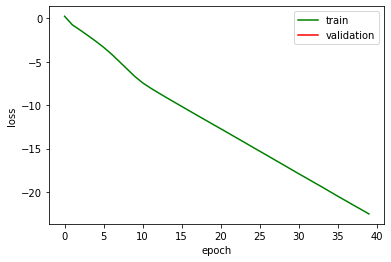

train_loss = -22.5205417585767 train_ppl = 12.812679431463204


In [39]:
loss, ppl, model = train(model_path)
print("train_loss =", loss, "train_ppl =", ppl)

In [0]:
# Clear the GPU memory
torch.cuda.empty_cache()

Measure the model's performance:

In [41]:
valid_ds = LMDataset('wikitext-2/valid.txt', word2id=word2id)
val_loss, val_ppl = evaluate(model, valid_ds)
print("valid_loss =", val_loss, "valid_ppl =", val_ppl)

Evaluation : Validation loss: -23.36527592884329
valid_loss = -23.36527592884329 valid_ppl = 1004.1850156634785


### 1.4 Text Generation (Optional: 1 pts)

Now, as the model has been trained on the dataset, it would be a good time to have some fun with it. In this section, we are going to use our language model to generate text. Specifically, given a small span of text, we want our model to complete the rest of it. To implement this, we simply input the initial text to the model, and then we predict the next words step-by-step. Predicting the next word can be achieved by taking the word that has the highest probability in the model's outputs (i.e., using `argmax`). However, it has been shown that naively taking the most probable word is not the best way to do it. Instead, we should sample the next word from the distribution the model puts on the vocabulary for each step (i.e., sampling from the model output).

Implement this mechanism in the following function:

In [0]:
def generate(input_words, model,  word2id, id2word, max_length, temperature):
  """
  Generate text given the input words

  Args:
    input_words (str): the input words. It needs tokenization
    model (ExtendedLM): the model
    word2id (Dict[str, int]), id2word (List[str]): the vocab
    max_length (int): the maximum number of words to generate
    temperature (float): the softmax temperature. A value between 0 and 1.
          see https://en.wikipedia.org/wiki/Softmax_function for more information.

  Returns:
    List[str]: generated text
  """
  tokens=word_tokenize(input_words)
  ids=torch.tensor(list(map(lambda t:word2id[t] if t in word2id else 0,tokens)),device=DEVICE).reshape(1,-1)
  count=0
  model.eval()
  hiddens=list(map(lambda hc:(hc[0].to(DEVICE),hc[1].to(DEVICE)),model.init_zero_state(1)))
  result=[]
  while count<=max_length:
    preds,hiddens,_=model(ids,hiddens)
    beta=1./temperature
    preds=F.softmax(beta*preds.squeeze(0))
    word=[id2word[w.item()] for w in Categorical(preds).sample()][-1]
    result+=[word]
    ids[0]=torch.cat([ids[0,1:],torch.tensor([word2id[word]],device=DEVICE)])
    count+=1
  return result

Check your implementation

In [43]:
generate("A complete edition including the three downloadable content packs was released a year ", model, word2id, id2word, 10, 0.5)

['.', 'the', '.', ')', '.', 'the', 'it', 'to', 'on', ',', ',']

In [44]:
generate('Environment is at risk!',
         model, word2id, id2word, 10, 0.5)

['at', ',', '.', 'that', ',', '<unk>', ',', ',', '<unk>', 'of', 'and']

## Submission

- Check and review your answers. Make sure all cells' output are what you have planned.
- Select File > Save.
- To download the notebook, select File > Download .ipynb.
- Create an archive of all notebooks (P1.ipynb, P2.ipynb, and P3.ipynb)

## References

1.   Gal, Yarin, and Zoubin Ghahramani. “A Theoretically Grounded Application of Dropout in Recurrent Neural Networks.” ArXiv:1512.05287 [Stat], October 5, 2016. http://arxiv.org/abs/1512.05287.
2.  Inan, Hakan, Khashayar Khosravi, and Richard Socher. “TYING WORD VECTORS AND WORD CLASSIFIERS: A LOSS FRAMEWORK FOR LANGUAGE MODELING.” In ICLR 2017, 13, 2017.
3. Merity, Stephen, Bryan McCann, and Richard Socher. “Revisiting Activation Regularization for Language RNNs.” ArXiv:1708.01009 [Cs], August 3, 2017. http://arxiv.org/abs/1708.01009.
4. Merity, Stephen, Nitish Shirish Keskar, and Richard Socher. “Regularizing and Optimizing LSTM Language Models.” ArXiv:1708.02182 [Cs], August 7, 2017. http://arxiv.org/abs/1708.02182.




